## Repeated Runs

To run the same simulation ten times, while guaranteeing replicability, we use a simple index (0...9) as the simulation's seed. Note that when the seed is not otherwise specified, 1234567 is used.

Average throughput time of customers for each of the 10 runs is printed out, along with a barplot graphic; this can be easily done for all other statistics, this is only a demo.

Data for run 1.
The average Customer visit lasted a total of 1538.71 seconds, or 25.65 minutes.

Data for run 2.
The average Customer visit lasted a total of 2605.14 seconds, or 43.42 minutes.

Data for run 3.
The average Customer visit lasted a total of 1386.48 seconds, or 23.11 minutes.

Data for run 4.
The average Customer visit lasted a total of 1126.4 seconds, or 18.77 minutes.

Data for run 5.
The average Customer visit lasted a total of 1424.07 seconds, or 23.73 minutes.

Data for run 6.
The average Customer visit lasted a total of 1431.0 seconds, or 23.85 minutes.

Data for run 7.
The average Customer visit lasted a total of 1601.72 seconds, or 26.7 minutes.

Data for run 8.
The average Customer visit lasted a total of 918.98 seconds, or 15.32 minutes.

Data for run 9.
The average Customer visit lasted a total of 1003.13 seconds, or 16.72 minutes.

Data for run 10.
The average Customer visit lasted a total of 1659.91 seconds, or 27.67 minutes.



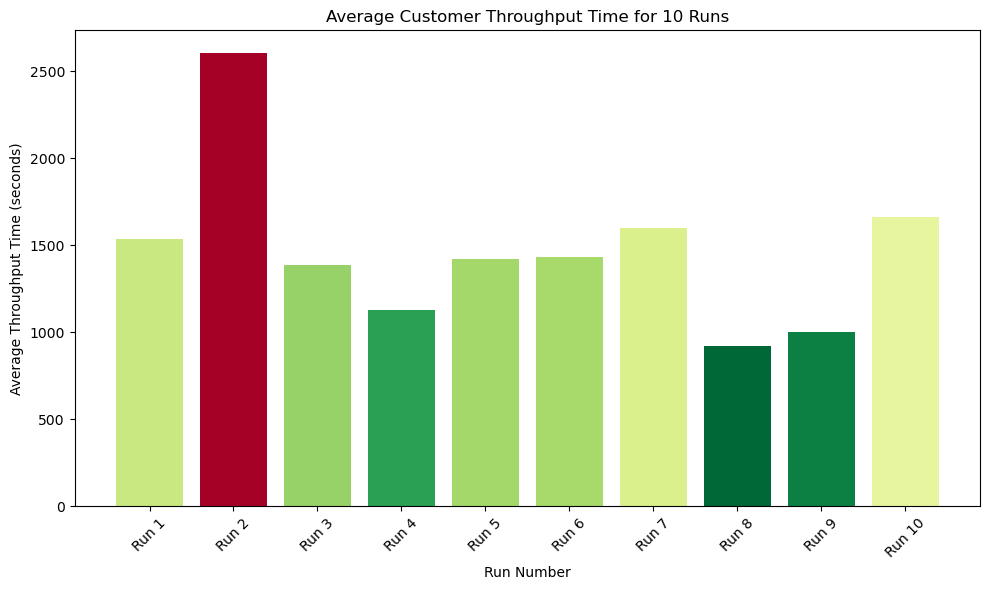

In [14]:
import salabim as sim
import matplotlib.pyplot as plt

# Initialize throughput_times list for graphic
average_throughput_times = []

# The index is used both for the replication and the random seed
for replication_number in range(10):
    
    # Environment must be reset every time we start a run
    sim.reset()        
    env = sim.Environment(time_unit='seconds')
    env.random_seed(replication_number)

    #Shopping baskets and carts:
    carts = env.Resource('carts', capacity=45) #45
    baskets = env.Resource('baskets', capacity=500)#several hundred
    cart_basket_distribution = sim.Pdf((carts, 0.8,baskets, 0.2))
    customer_basketcart_distribution_monitor = sim.Monitor("Customer basket and cart monitor")
    #shopping categories:
    # fruit_and_vegetables 
    # meat_and_fish
    # bread
    # cheese_and_dairy
    # canned_and_packed_food
    # frozen_foods
    # drinks
    item_taking_distribution = sim.Uniform(20,30)

    #Clerks
    #Bread and cheese use resources as they are working via counters. Checkout likely has to use queue as the customers need to choose the smallest one
    bread_clerks = env.Resource('bread_clerks', capacity=4) #4 employees, 1-6 items takes 2 min
    bread_time_distribution = sim.Exponential(2*60)
    cheese_and_dairy_clerks = env.Resource('bread_clerks', capacity=3) #3 employees, 1 min avg.
    cheese_and_dairy_time_distribution = sim.Exponential(1*60)

    #Checkouts
    number_of_checkouts = 3
    time_per_item_distribution = sim.Exponential(1.1)
    payment_time_distribution = sim.Uniform(40, 60)

    #Distributions of items per customer
    fruit_and_vegetables_distribution = sim.Triangular(4, 22,10)  # min=4, mode=10, max=22
    meat_and_fish_distribution = sim.Triangular(0, 9, 4)           # min=0, mode=4, max=9
    bread_distribution = sim.Triangular(1, 10, 4)                  # min=1, mode=4, max=10
    cheese_and_dairy_distribution = sim.Triangular(1, 11, 3)       # min=1, mode=3, max=11
    canned_and_packed_food_distribution = sim.Triangular(6, 35, 17)# min=6, mode=17, max=35
    frozen_foods_distribution = sim.Triangular(2, 19, 8)           # min=2, mode=8, max=19
    drinks_distribution = sim.Triangular(1, 20, 9)                 # min=1, mode=9, max=20

    #Route choice distribution

    #Routes
    route1 = [
    "fruit_and_vegetables",
    "meat_and_fish",
    "bread",
    "cheese_and_dairy",
    "canned_and_packed_food",
    "frozen_foods",
    "drinks",
    ] #ABCDEF, 80% 

    route2 = [
    "meat_and_fish",
    "bread",
    "cheese_and_dairy",
    "fruit_and_vegetables",
    "canned_and_packed_food",
    "frozen_foods",
    "drinks",
    ] #BCDEFG, 20%

    route_distribution = sim.Pdf((route1, 0.8, route2, 0.2))

    ### CHANGE HERE ###
    all_customers = []

    class Customer(sim.Component):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.route = route_distribution.sample()
            self.shopping_list = {
                "fruit_and_vegetables": int(round(fruit_and_vegetables_distribution.sample())),
                "meat_and_fish": int(round(meat_and_fish_distribution.sample())),
                "bread": int(round(bread_distribution.sample())),
                "cheese_and_dairy": int(round(cheese_and_dairy_distribution.sample())),
                "canned_and_packed_food": int(round(canned_and_packed_food_distribution.sample())),
                "frozen_foods": int(round(frozen_foods_distribution.sample())),
                "drinks": int(round(drinks_distribution.sample())),
            }
            self.progress = 0
            self.carrying = None
            self.actions_log = []

            all_customers.append(self)

        def log_action(self, action):
                """Helper function to log an action with the current time."""
                self.actions_log.append((env.now(), action))

        def process(self):
            """"
            Process determines what the customer will do. At the start they will take a cart or basket. Afterwards they will traverse their route and take the items they need according to their shopping list. If they have finished their route (when progress is equal to the length of the shopping list), they will go to the checkout.
            """
            self.start_shopping()
            for next_product in self.route:
                if self.shopping_list[next_product]>0:
                    self.get_product(next_product)   
            self.go_to_checkout()

        def start_shopping(self):
            #Get shopping cart or basket
            want_to_carry = cart_basket_distribution.sample()
            self.log_action(f"Entered cart/basket queue for {want_to_carry}")
            self.request(want_to_carry)
            customer_basketcart_distribution_monitor.tally(want_to_carry)
            self.log_action(f"Got {want_to_carry}")
            self.carrying = want_to_carry

        def go_to_checkout(self):
            #enter emptiest queue
            emptiest_queue = min(checkouts, key=lambda checkout: checkout.requesters().length()) 
            self.log_action(f"Entered checkout queue {emptiest_queue}")
            self.request(emptiest_queue) 
            self.log_action(f"Started checking out")
            item_scan_time = sum(time_per_item_distribution.sample() for _ in range(sum(self.shopping_list.values())))
            self.hold(item_scan_time+payment_time_distribution.sample()) #hold the customer for scanning all items and during payment
            self.log_action(f"Finished checking out")
            #return cart/basket       
            #print log if we want to debug
            '''
            if customer_to_log:
                if self.name() == f"customer.{customer_to_log}":
                    print(self.carrying.claimers().print_info())
                    print(f"Customer's Action Log for customer {self.name()}:")
                    for time, action in self.actions_log:
                        print(self)
                        print(f"At time {time}, customer: {action}")
            '''

        def get_product(self, product):
            #Move to product location #<- only needed in animation
            if product == "cheese_and_dairy":
                self.log_action(f"requesting cheese and dairy")
                self.request(cheese_and_dairy_clerks)
                self.log_action(f"Being helped for cheese and dairy")
                self.hold(cheese_and_dairy_distribution.sample())
                self.log_action(f"Got cheese and dairy")
                self.release(cheese_and_dairy_clerks)
            elif product == "bread":
                self.log_action(f"requesting bread")
                self.request(bread_clerks)
                self.log_action(f"Being helped for bread")
                self.hold(bread_time_distribution.sample())
                self.log_action(f"Got bread")
                self.release(bread_clerks)
            else:
                amount = self.shopping_list[product]
                self.log_action(f"Getting {product}")
                for _ in range(amount):
                    self.hold(time_per_item_distribution.sample())
                    self.log_action(f"Got {product}")

    #customer generation
    customer_distribution = [30, 80, 110, 90, 80, 70, 80, 90, 100, 120, 90, 40] #Expected total = 980
    for index, customer_count  in enumerate(customer_distribution):
        env.ComponentGenerator(Customer, iat=env.Exponential(3600/customer_count), at=index*60*60, duration=60*60) #assumes time in seconds
        # print(customer_count)
    customer_arrival_monitor = sim.Monitor("Customer arrival monitor")

    checkouts = [] #dictionary to map checkouts to clerks
    for i in range(number_of_checkouts):
        checkouts.append(env.Resource(f"checkout_clerk{i}", capacity = 1)) #3, 1.1s per item avg. payment 40-60s

    env.run(duration=60*60*12)
    
    ####################################
    ###### THROUGHPUT COLLECTION #######
    ####################################
    
    
    # Initializing empty throughput list
    print(f'Data for run {replication_number + 1}.')
    throughput_times = []

    # Loop over customers in the list
    for customer in all_customers:
        # If the customer's last action is not 'Finished checking out', they aren't taken into account
        if customer.actions_log[-1][1] != 'Finished checking out':
            continue
        
        first_action_time = customer.actions_log[0][0]
        last_action_time = customer.actions_log[-1][0]
        # Throughput calculation and appending to main list
        throughput_time = last_action_time - first_action_time
        throughput_times.append(throughput_time)

    average_throughput = sum(throughput_times) / len(throughput_times)
    # Append the average throughput to the list for the graphic
    average_throughput_times.append(average_throughput)

    print(f'The average Customer visit lasted a total of {round(average_throughput, 2)} seconds, or {round(average_throughput/60, 2)} minutes.\n')

##################
### GRAPH CODE ###
##################


colors = []
max_time = max(average_throughput_times)
min_time = min(average_throughput_times)

# Create colors based on the throughput time (green for shorter times, red for longer)
for time in average_throughput_times:
    normalized = (time - min_time) / (max_time - min_time)  # Normalize between 0 and 1
    colors.append(plt.cm.RdYlGn_r(normalized))  # Using RdYlGn_r colormap (green to red)

run_numbers = [f"Run {i+1}" for i in range(len(average_throughput_times))]

plt.figure(figsize=(10, 6))
plt.bar(run_numbers, average_throughput_times, color=colors)

# Adding title and labels
plt.title('Average Customer Throughput Time for 10 Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Throughput Time (seconds)')

# Displaying the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()